# [LSTM Monthly Temperature Prediction Example](LSTMPyTorch)

Most of the time, the weather of one city is heavily related to its weather in the past. In fact, the weather should follow some seasonal patterns. Hence, in this example, we use Long-Short-Term-Memory Neural Network (LSTM) to find this hidden seasonal pattern in the temperature, and then make some sensible predictions for the future.

Reference:
- [Time Series Prediction with LSTM](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python)
- [Weather Forecasting with RNN](https://medium.com/analytics-vidhya/weather-forecasting-with-recurrent-neural-networks-1eaa057d70c3)
- [PyTorch LSTM Manual](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)


Import related libraries:

In [17]:
'''Train with PyTorch.'''
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data

# SciKit
from sklearn.preprocessing import MinMaxScaler

# Python
import pandas as pd
import numpy as np
import os
import time

Declaring machine learning parameters:

In [48]:
# ML Parameters
lr = 1e-3
epoch = 500  # 500
batch_size = 20  # 20

# Input Dataset
input_datase_file = './surface-air-temperature-monthly-mean.csv'

# Normalization
scaler = MinMaxScaler(feature_range=(-1, 1))


Check if Pandas can read the dataset correctly:

In [49]:
# Load Dataset
df = pd.read_csv(input_datase_file, names = ["month", "mean_temp"], header=0) # read 2 columns
df.head()

,month,mean_temp
0,1982-01,25.9
1,1982-02,27.1
2,1982-03,27.2
3,1982-04,27.0
4,1982-05,28.0


Take 70% of data as training set, and 30% of data as validation set:

Make it as PyTorch Dataset Class. This class assumes **the data is previous X month temperature, and the target is the 6th month temperature**:

[$t_1$ $t_2$ $t_3$ $t_4$ $t_5$ ... $t_x$] --> [$t_{x+1}$]

[$t_2$ $t_3$ $t_4$ $t_5$ ... $t_{x+1}$] --> [$t_{x+2}$]

...

[$t_{n-5}$ $t_{n-4}$ $t_{n-3}$ $t_{n-2}$ $t_{n-1}$ ... $t_{x+1-n}$] --> [$t_n$]


In [50]:
df = pd.read_csv(input_datase_file, names = ["month", "mean_temp"], header=0) # read 2 columns
orig_dataset = df.mean_temp.to_numpy()  # temperature

# store another normalized dataset
normalized_dataset = np.copy(orig_dataset)  
normalized_dataset = normalized_dataset.reshape(-1)

# normalized_dataset = scaler.fit_transform(normalized_dataset)

# print(type(normalized_dataset))
# print(normalized_dataset)

In [52]:
class TemperatureDataset(data.Dataset):

    def __init__(self):
        
        # read CSV
        self.df = pd.read_csv(input_datase_file, names = ["month", "mean_temp"], header=0) # read 2 columns
        self.orig_dataset = df.mean_temp.to_numpy()  # temperature
        
        # store another normalized dataset
        self.normalized_dataset = np.copy(self.orig_dataset)  
        self.normalized_dataset = self.normalized_dataset.reshape(-1, 1)  # (row, column): -1:不限;1:一(直)行

        # calculate normalization
        self.normalized_dataset = scaler.fit_transform(self.normalized_dataset)  # normalize氣溫至-1~1
        self.normalized_dataset = self.normalized_dataset.reshape(-1)  # 變成一維
        
        # use X history data (X months) generate one target 
        self.sample_len = 18  # 用18個月預測下一個月的氣溫

    def __len__(self):
        # 回傳資料長度
        
        if len(self.orig_dataset) > self.sample_len:
            return len(self.orig_dataset) - self.sample_len
        else:
            return 0

    def __getitem__(self, idx):
        # 用索引值取得資料
        
        # target is the last records
        target = self.normalized_dataset[self.sample_len+idx]  # 第X+1個月
        target = np.array(target).astype(np.float64)  # convert to numpy array
        
        # data is the previous five records
        i = self.normalized_dataset[idx:(idx+self.sample_len)]

        # LSTM requires time-series data to shape in this way
        i = i.reshape((-1, 1))
        
        # convert to PyTorch tensors
        i = torch.from_numpy(i)
        target = torch.from_numpy(target)
        
        return i, target


Preparation of training and validation set:

**DataLoader** 把dataset轉換為iteration

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load dataset
dataset = TemperatureDataset()

# Split training and validation set
train_len = int(0.7*len(dataset))
valid_len = len(dataset) - train_len
TrainData, ValidationData = random_split(dataset,[train_len, valid_len])

# Load into Iterator (each time get one batch)
train_loader = data.DataLoader(TrainData, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = data.DataLoader(ValidationData, batch_size=batch_size, shuffle=True, num_workers=0)

# Print statistics
print("Total: ", len(dataset))
print("Training Set: ", len(TrainData))
print("Validation Set: ", len(ValidationData))


Total:  448
Training Set:  313
Validation Set:  135


Our Machine Learning model is a Fully-Connected LSTM:

[參數](https://clay-atlas.com/blog/2020/05/12/pytorch-lstm-%E7%9A%84%E5%8E%9F%E7%90%86%E8%88%87%E8%BC%B8%E5%85%A5%E8%BC%B8%E5%87%BA%E6%A0%BC%E5%BC%8F%E7%B4%80%E9%8C%84/)

```python
    class LSTM(
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        bias: bool = True,
        batch_first: bool = False,
        dropout: float = 0,
        bidirectional: bool = False,
        proj_size: int = 0,
        device: Any | None = None,
        dtype: Any | None = None
    )
```
- input_size: 輸入x的特徵數量 <font color='orange'>(用幾個欄位預測)</font>
- hidden_size: 隱藏層h的特徵數量
- num_layers: LSTM的循環層數 (default=1)
- bias: 若為False，則bias初始化為0 (default=True)
- batch_first: 若為True，則輸入維度為 (batch_size, seq_len, feature)
- dropout: 若不為0，則在每一層LSTM後都會接著dropout (default=0)
- bidirectional: 若為True，則為雙向LSTM (default=False)

---
```python
class Linear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    device: Any | None = None,
    dtype: Any | None = None
)
```
- in_features: 輸入的數量
- out_features: 輸出的數量
- bias: 就是bias (default=True)

---
```python
# Parameters
self.feature_dim = 1 (-> input_size)
self.hidden_dim = 500  (-> hidden_size / in_features)
self.num_layers = 3  
self.output_dim = 1  (-> out_features)

# Neural Networks
self.lstm = nn.LSTM(self.feature_dim, self.hidden_dim, self.num_layers, dropout=0.1, batch_first=True)
self.fc = nn.Linear(self.hidden_dim , self.output_dim)
```

> TempLSTM(  
&emsp;&emsp;(lstm): LSTM(1, 500, num_layers=3, batch_first=True, dropout=0.1)  
&emsp;&emsp;(fc): Linear(in_features=500, out_features=1, bias=True)  
)

---
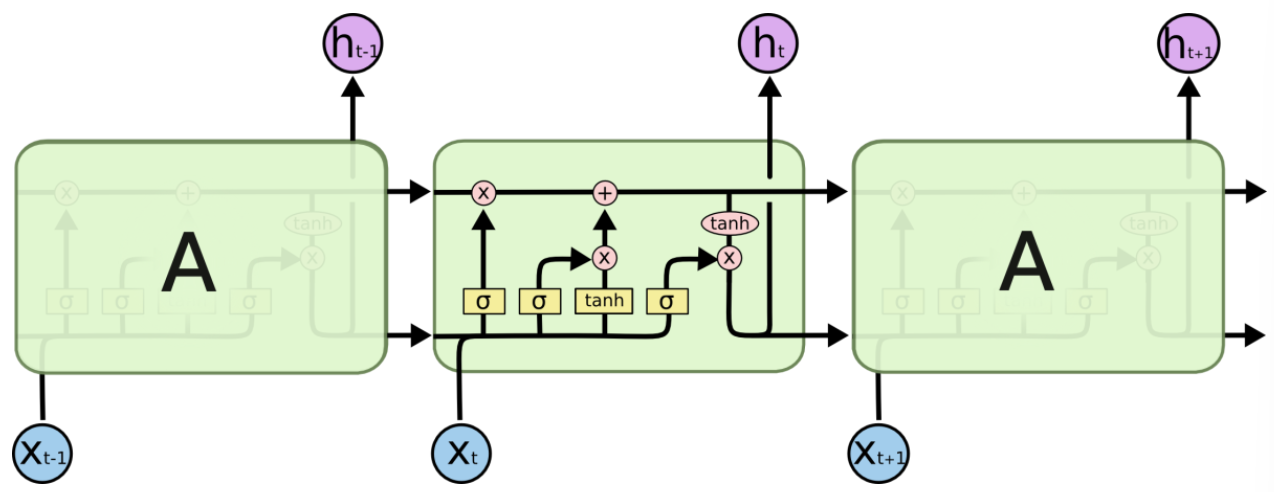

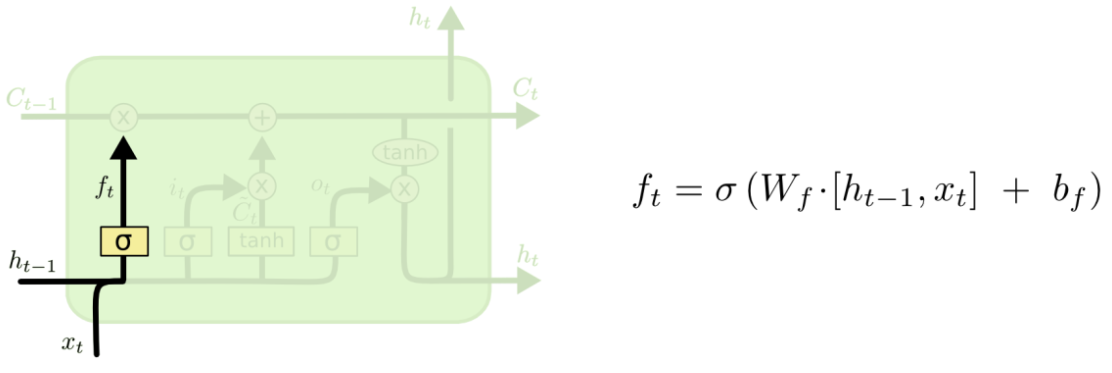
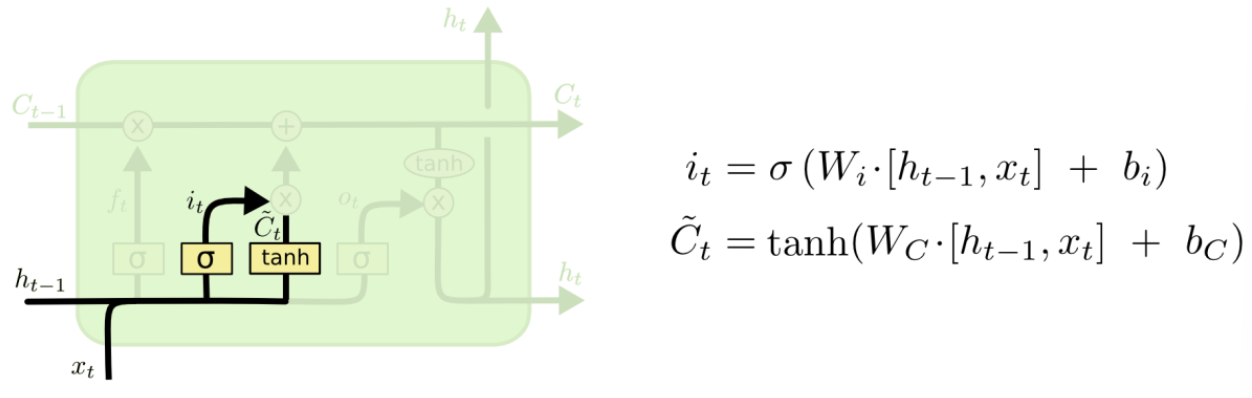
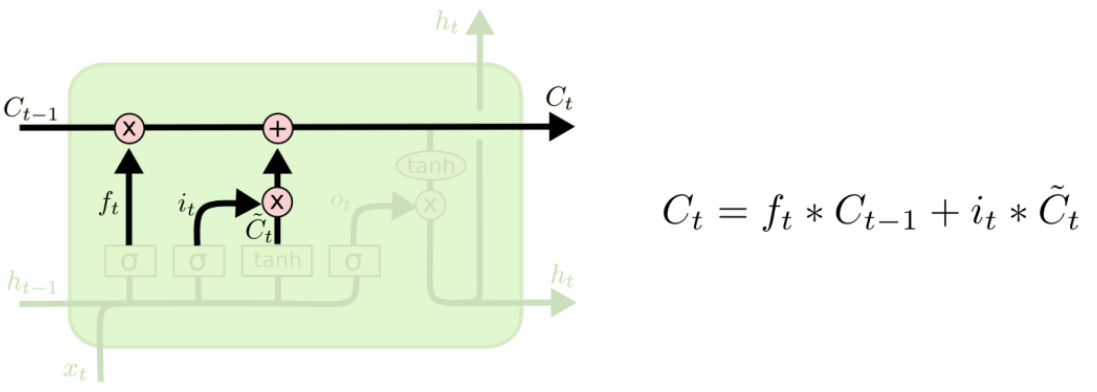
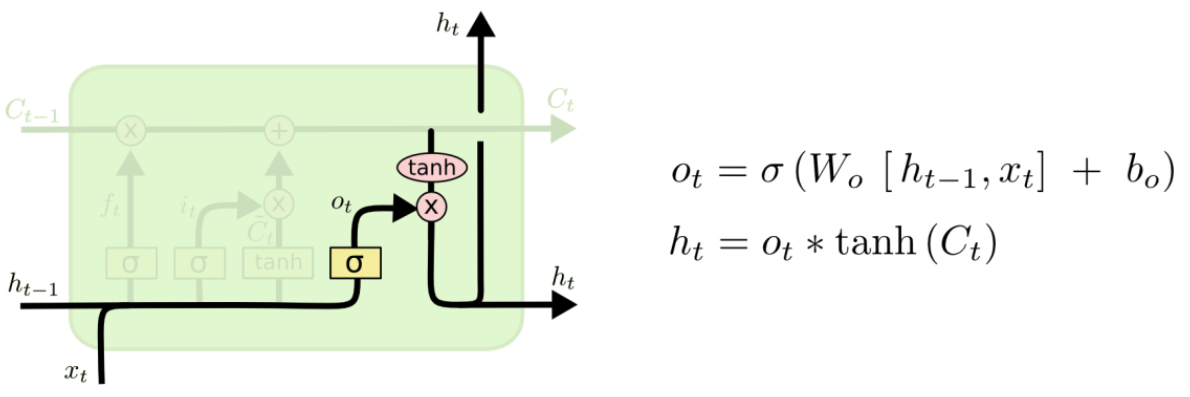

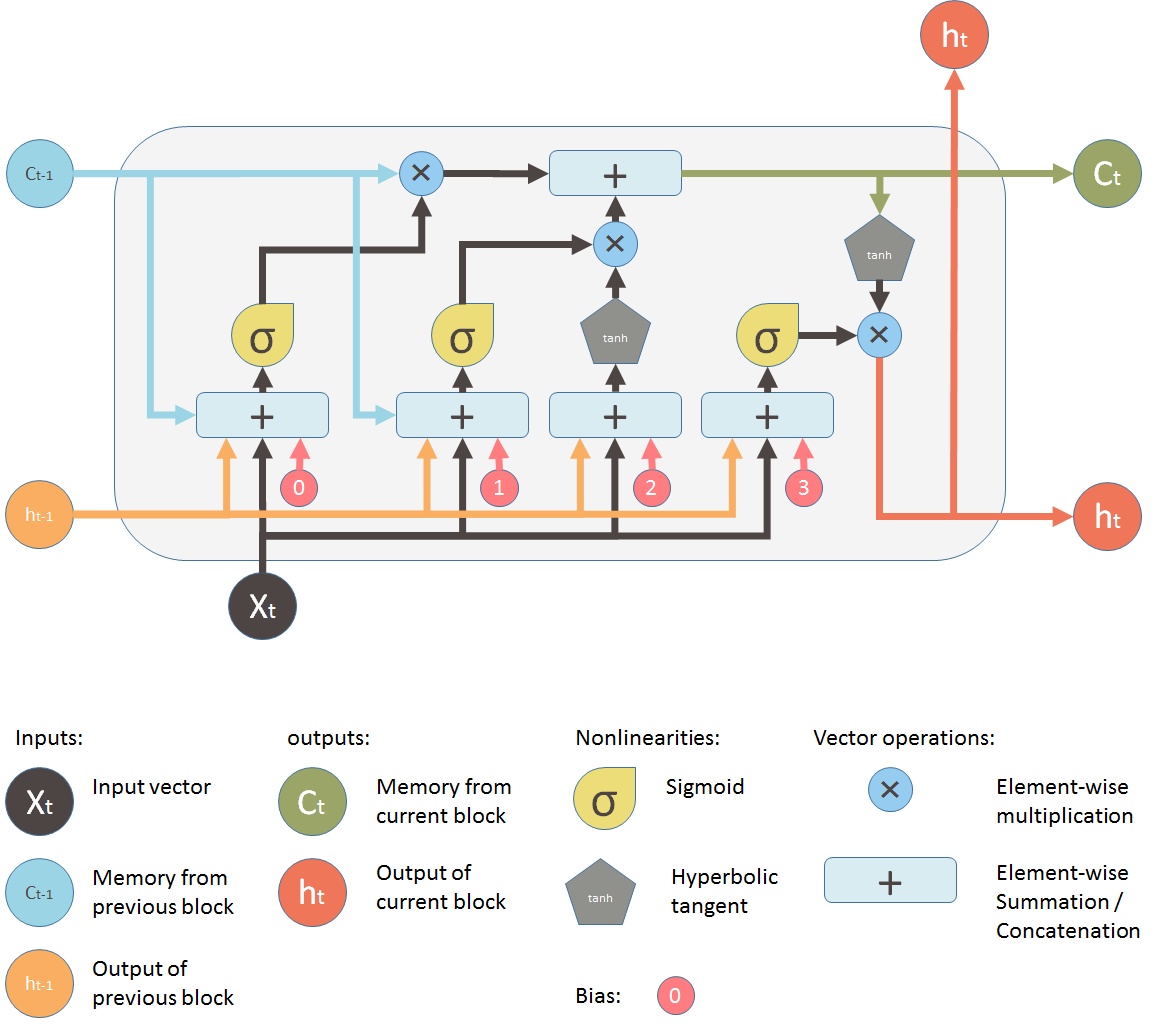

In [53]:
class TempLSTM(nn.Module):

    def __init__(self):

        # Required in PyTorch Model
        super(TempLSTM, self).__init__()
        
        # Parameters
        self.feature_dim = 1
        self.hidden_dim = 500
        self.num_layers = 3
        self.output_dim = 1

        # Neural Networks
        self.lstm = nn.LSTM(self.feature_dim, self.hidden_dim, self.num_layers, dropout=0.1, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim , self.output_dim)
        
    def forward(self, i):

        # Set initial hidden and cell states
        h0 = torch.zeros([self.num_layers, i.shape[0], self.hidden_dim], dtype=torch.double).to(i.device) #.requires_grad_()
        c0 = torch.zeros([self.num_layers, i.shape[0], self.hidden_dim], dtype=torch.double).to(i.device) #.requires_grad_()

        # Forward propagate LSTM
        # detach() is used to prevent backpropagating to the start of the sequence
        # _是隱藏狀態(這邊不需要)
        out, _ = self.lstm.forward(i, (h0.detach(), c0.detach()))  # output shape (batch, sequence, hidden_dim)
        out = self.fc(out[:, -1, :])  # 只取最後一個時間點的output
        return out

Define and build machine learning model:

In [54]:
# Define model
model = TempLSTM()
model = model.double()
print(model)

# Load into GPU if necessary
model = model.to(device)

# Define loss function
criterion = nn.MSELoss()
#criterion = nn.MSELoss(reduction='sum')

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=5e-4)


TempLSTM(
  (lstm): LSTM(1, 500, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


Training and Testing Functions:

In [56]:
###########################
# Train with training set #
###########################
train_loss_list = []
def train(model, iterator, optimizer, criterion, device):
    
    model.train()     # Enter Train Mode
    train_loss = 0

    for _, (ii, targets) in enumerate(iterator):
        
        # move to GPU if necessary
        # ii: input datas / targets: target data(ii要預測的氣溫)
        ii, targets = ii.to(device), targets.to(device)
        
        # generate prediction
        optimizer.zero_grad()  # clear gradients (before update weights)
        preds = model(ii)
        preds = preds.view(-1)  # 改為一維
        
        # calculate loss
        loss = criterion(preds, targets)

        # compute gradients and update weights
        loss.backward()  # 將loss向input反向傳播
        optimizer.step()  # 更新weight
        
        # record training losses
        train_loss += loss.item()

    # print completed result
    print('train_loss: %f' % (train_loss))
    train_loss_list.append(train_loss)
    return train_loss


#############################
# Validate with testing set #
#############################
test_loss_list = []
def test(model, iterator, criterion, device):

    model.eval()     # Enter Evaluation Mode
    test_loss = 0

    with torch.no_grad():
        for _, (ii, targets) in enumerate(iterator):

            # move to GPU if necessary
            ii, targets = ii.to(device), targets.to(device)
            
            # generate prediction
            preds = model(ii)
            preds = preds.view(-1)
            
            # convert target tensor to long
            targets = targets.long()
            
            # calculate loss
            loss = criterion(preds, targets)
            
            # record training losses
            test_loss += loss.item()
    
    # print completed result
    print('test_loss: %s' % (test_loss))
    test_loss_list.append(test_loss)
    return test_loss


##################################
# Use the model to do prediction #
##################################
def predict(model, device, data):
    model.eval()     # Enter Evaluation Mode
    with torch.no_grad():
        pred = model(data)
        return pred


Acutal execution:

- Run `training()` and `test()` for `epoch` times
- Save best results information


In [57]:
# Running
for epoch in range(epoch):
    print("===== Epoch %i =====" % epoch)
    train(model, train_loader, optimizer, criterion, device)
    test(model, test_loader, criterion, device)

===== Epoch 0 =====
train_loss: 2.361798
test_loss: 0.06304754122585995
===== Epoch 1 =====
train_loss: 1.769112
test_loss: 0.14818012308451772
===== Epoch 2 =====
train_loss: 1.420305
test_loss: 0.5948409567703372
===== Epoch 3 =====
train_loss: 1.114330
test_loss: 0.35551419460671374
===== Epoch 4 =====
train_loss: 1.033231
test_loss: 0.8362422318081962
===== Epoch 5 =====
train_loss: 1.003138
test_loss: 0.8199328911997102
===== Epoch 6 =====
train_loss: 0.871358
test_loss: 0.8468904023098736
===== Epoch 7 =====
train_loss: 0.966803
test_loss: 0.7715244352812323
===== Epoch 8 =====
train_loss: 0.929674
test_loss: 0.8144248545170945
===== Epoch 9 =====
train_loss: 0.874371
test_loss: 0.8794521664772343
===== Epoch 10 =====
train_loss: 0.841467
test_loss: 1.044601595936085
===== Epoch 11 =====
train_loss: 0.852490
test_loss: 0.7879892644328504
===== Epoch 12 =====
train_loss: 0.825402
test_loss: 0.7553546526339757
===== Epoch 13 =====
train_loss: 0.801203
test_loss: 0.989733584416223
=

視覺化loss

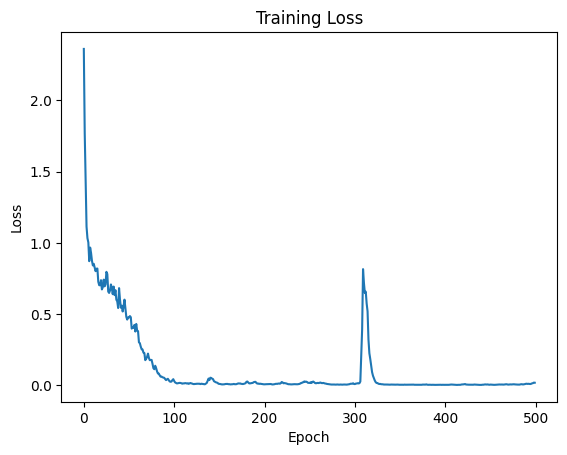

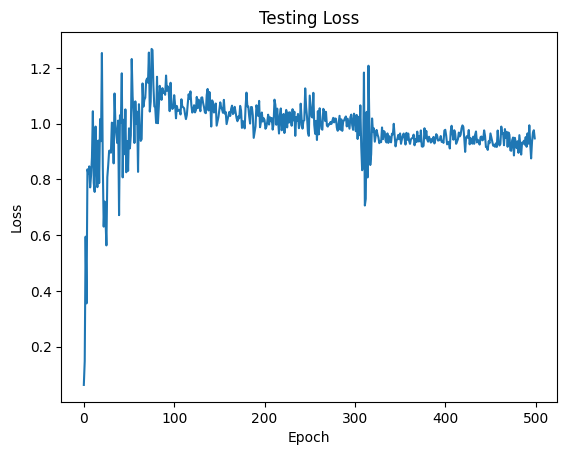

In [58]:
import matplotlib.pyplot as plt

def plot_train_loss(train_loss_list):
    plt.figure()
    plt.plot(range(len(train_loss_list)), train_loss_list)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def plot_test_loss(test_loss_list):
    plt.figure()
    plt.plot(range(len(test_loss_list)), test_loss_list)
    plt.title('Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

plot_train_loss(train_loss_list)
plot_test_loss(test_loss_list)

Use the trained model to predict temperature:

In [59]:
# Predicting N months
N = 12  # 預測未來N個月的氣溫

# Extract the second column
mean_temps = df.mean_temp

# Pick P points randomly in data as starting
P = 10  # 10組prediction
points = np.random.randint(dataset.sample_len, high=len(dataset), size=P)  # 隨機抓每一組的預測起始點
preds = np.zeros((P, N))

# Forcast temperature for N months
for idx_i, i in enumerate(points):
    normalized_temp, target = dataset[i]
    temperatures = normalized_temp
    temperatures = temperatures.to(device)
    
    for idx_j, j in enumerate(range(N)):
        
        ii = temperatures.view(1, dataset.sample_len+idx_j, 1).to(device)   # transform into (batch, sequence, features)
        model = model.to(device)
        pred = predict(model, device, ii).to(device)
        preds[idx_i][idx_j] = pred

        # remove first temp and append predicted data at last
        # temperatures = torch.cat((temperatures[1:], pred.view(-1)))
        temperatures = torch.cat((temperatures, pred))
    
    # Inverse transform the predictions
    actual_predictions = scaler.inverse_transform(preds[idx_i].reshape(-1, 1))  # 從normalization轉為原始氣溫值  
    preds[idx_i] = actual_predictions.reshape(-1)
    print("Predicts: ", actual_predictions)
    print("Expected: ", scaler.inverse_transform(target.reshape(-1, 1)))

Predicts:  [[26.71133081]
 [26.5065692 ]
 [28.15948042]
 [28.48117442]
 [28.15168043]
 [27.95902641]
 [27.88080526]
 [27.82157176]
 [27.68066073]
 [27.18122616]
 [26.60717265]
 [26.59974718]]
Expected:  [[26.7]]
Predicts:  [[27.77175892]
 [27.77672155]
 [27.49438634]
 [27.06189669]
 [26.93831523]
 [27.25460353]
 [27.60103509]
 [28.2554102 ]
 [28.63002776]
 [28.99586292]
 [29.07865689]
 [28.76729213]]
Expected:  [[27.7]]
Predicts:  [[27.71354119]
 [27.6092542 ]
 [27.99110347]
 [27.93120376]
 [27.75118299]
 [27.71961274]
 [27.40405735]
 [26.93825508]
 [26.90447525]
 [27.22895472]
 [27.6233346 ]
 [28.19766277]]
Expected:  [[28.6]]
Predicts:  [[28.85282346]
 [28.2143809 ]
 [28.438159  ]
 [28.32940354]
 [28.06683105]
 [27.46632322]
 [27.81226744]
 [28.32369846]
 [28.92078364]
 [29.05282903]
 [29.15899444]
 [29.04396   ]]
Expected:  [[28.1]]
Predicts:  [[26.39936578]
 [26.57878797]
 [27.13170565]
 [27.12729753]
 [27.79126401]
 [28.18274065]
 [28.4911758 ]
 [27.98416773]
 [27.49077811]
 [27.7

Visualize the prediction results:

Predicted months:  range(295, 307)
Predicted months:  range(289, 301)
Predicted months:  range(202, 214)
Predicted months:  range(240, 252)
Predicted months:  range(270, 282)
Predicted months:  range(71, 83)
Predicted months:  range(142, 154)
Predicted months:  range(33, 45)
Predicted months:  range(217, 229)
Predicted months:  range(206, 218)


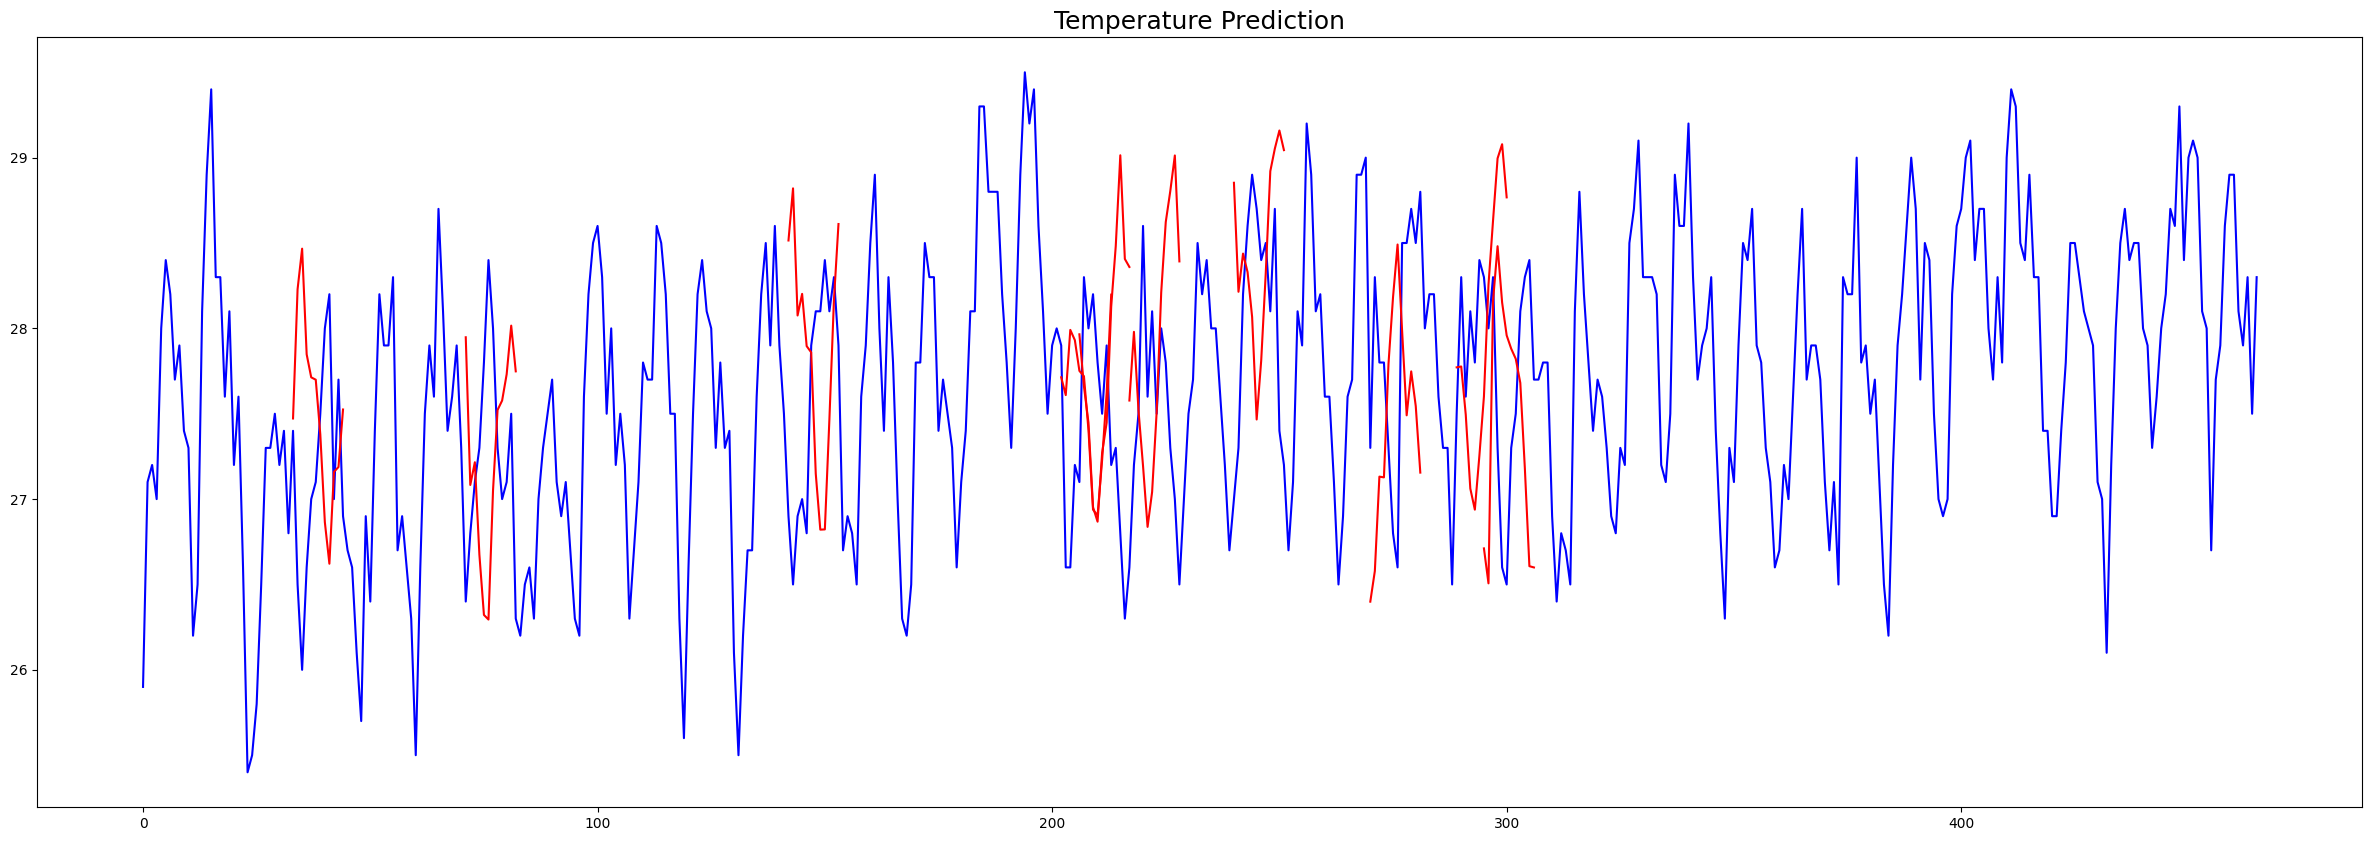

In [60]:
import matplotlib.pyplot as plt

# Data
months = range(0, df.month.size)

# Draw Inline
%matplotlib inline

# Draw Original Lines
plt.figure(figsize = (30,10))
plt.title('Temperature Prediction', fontsize=18)
plt.plot(months, mean_temps, color='b')

# Draw all predicted points
for idx_i, i in enumerate(points):
    i_months = range(i, i+N)
    i_temps = preds[idx_i]
    plt.plot(i_months, i_temps, color='r')
    print("Predicted months: ", i_months)
